In [ ]:
! pip install transformers datasets
! pip install evaluate
! pip install sentence-transformers
! pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

### Προσοχή

Μη διαγράψετε τα # insert your code here σχόλια, καθώς βοηθούν στη διόρθωση. Συμπληρώστε τον κώδικά σας μετά από τα σχόλια αυτά.

# Μέρος Α: Fine-tune a pretrained model

Τα γλωσσικά μοντέλα αποτελούνται από δύο στάδια εκπαίδευσης:
1. Pre-training σε μεγάλα unlabelled datasets. Το pre-training είναι υπολογιστικά πολύ ακριβό και γι αυτό στην πράξη δε το χρησιμοποιούμε όταν θέλουμε να τρέξουμε ένα μοντέλο σε ένα καινούργιο dataset. Μπορούμε να σκεφτούμε το pre-training ως τη διαδικασία εκμάθησης γλωσσικών κανόνων κι εννοιών, οι οποίες στη συνέχεια μπορούν να χρησιμοποιηθούν για διάφορους σκοπούς.

2. Fine-tuning σε μικρότερα labelled datasets. Το fine-tuning πρακτικά εκμεταλλεύεται τις ιδιότητες του transfer learning προκειμένου να μεταφέρουμε τη 'γνώση' που έχει αποθηκευθεί στο γλωσσικό μοντέλο κατά τη διάρκεια του pre-training σε συγκεκριμένα task. Κάθε task εξυπηρετείται μέσω στοχευμένων datasets. Για παράδειγμα, κάποια datasets αναφέρονται στην ταξινόμηση κειμένων σε κατηγιορίες (text classification), άλλα datasets περιέχουν ερωτήσεις οι οποίες πρέπει να απαντηθούν (question answering) κι άλλα πολλά.

Κάποια κλασικά tasks της επεξεργασίας φυσικής γλώσσας είναι τα ακόλουθα:
- Text classification
- Question answering
- Natural language inference
- Fill mask
- Semantic similarity

Περισσότερες πληροφορίες μπορείτε να βρείτε στον ακόλουθο σύνδεσμο στο domain Natural Language Processing: https://huggingface.co/models

Στο πρώτο κομμάτι της παρούσας εργαστηριακής άσκησης, θα χρησιμοποιήσουμε το pre-training fine-tuning σενάριο για να ταξινομήσουμε reviews.

## Pipelines

Με τη χρήση του text-classification pipeline μπορούμε να τρέξουμε γλωσσικά μοντέλα που αφορούν tasks ταξινόμησης. Το natural language inference (NLI) task αποτελεί ένα task ταξινόμησης, αφού το σχετικό μοντέλο (εν προκειμένω το roberta-large-mnli) καλείται να ταξινομήσει ένα κείμενο σε μία από τις 3 κατηγορίες [entailment/neutral/contradiction].

```
from transformers import pipeline

classifier = pipeline("text-classification", model = "roberta-large-mnli")
classifier("A soccer game with multiple males playing. Some men are playing a sport.")
## [{'label': 'ENTAILMENT', 'score': 0.98}]
```

Ένα άλλο task ταξινόμησης αφορά την αξιολόγηση του κατά πόσο ένα κείμενο είναι γραμματικά ορθό (acceptable) ή όχι (unacceptable):

```
from transformers import pipeline

classifier = pipeline("text-classification", model = "textattack/distilbert-base-uncased-CoLA")
classifier("I will walk to home when I went through the bus.")
##  [{'label': 'unacceptable', 'score': 0.95}]
```

## Σύνολο δεδομένων Yelp polarity

Κατεβάζουμε το [Yelp Polarity](https://huggingface.co/datasets/yelp_polarity) dataset το οποίο περιέχει reviews που εκφράζουν συναισθήματα πελατών για εστιατόρια. Τα reviews αυτά χωρίζονται σε κατηγορίες, και ο σκοπός μας είναι να κατηγοριοποιήσουμε νέα reviews στις σωστές κατηγορίες.

In [ ]:
from datasets import load_dataset

# insert your code here

dataset = load_dataset("yelp_polarity")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for yelp_polarity contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yelp_polarity
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Επειδή το σύνολο δεδομένων του Yelp Polarity περιέχει πολλά δείγματα, προκειμένου να επιταχύνουμε τη διαδικασία του fine-tuning συστήνουμε να διατηρήσετε 300 δείγματα από το train set και 300 δείγματα από το test set.

Ελέγξτε τον αριθμό κατηγοριών που υπάρχουν συνολικά στο train και το test set και διατηρήστε ισορροπημένο αριθμό δειγμάτων ανά κατηγορία για τα σύνολα αυτά κατά την επιλογή των 300 δειγμάτων.

In [ ]:
# Check the number of categories in the train and test set
train_categories = dataset["train"].unique("label")
test_categories = dataset["test"].unique("label")

# Calculate how many samples to retain from each category
samples_per_category_train = 300 // len(train_categories)
samples_per_category_test = 300 // len(test_categories)

# Select random samples from each category in the train and test set
import random

train_indices = []
test_indices = []

for category in train_categories:
    category_indices = [i for i, ex in enumerate(dataset["train"]) if ex["label"] == category]
    train_indices.extend(random.sample(category_indices, min(samples_per_category_train, len(category_indices))))

for category in test_categories:
    category_indices = [i for i, ex in enumerate(dataset["test"]) if ex["label"] == category]
    test_indices.extend(random.sample(category_indices, min(samples_per_category_test, len(category_indices))))

# Filter the dataset using the selected indices
train_dataset = dataset["train"].select(train_indices)
test_dataset = dataset["test"].select(test_indices)

# Confirm the number of samples in the new filtered train and test sets
print("Number of samples in the new filtered train set:", len(train_dataset))
print("Number of samples in the new filtered test set:", len(test_dataset))


Number of samples in the new filtered train set: 300
Number of samples in the new filtered test set: 300


In [ ]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 300
})

# Language Models

Η προεπεξεργασία των κειμένων προηγείται της εισόδου τους στα γλωσσικά μοντέλα. Η διαδικασία αυτή επιτελείται μέσω των Tokenizers, τα οποία μετατρέπουν τα tokens εισόδου σε κατάλληλα IDs του λεξιλογίου προεκπαίδευσης, κι έτσι μετατρέπουν το κείμενο σε μορφή που μπορεί να επεξεργαστεί κάποιο μοντέλο Transformer. Η βιβλιοθήκη Huggingface προσφέρει εύκολες και high-level υλοποιήσεις tokenization, τις οποίες συστήνουμε να ακολουθήσετε στη συνέχεια.

Συγκεκριμένα, αρχικοποιούμε τη διαδικασία του tokenization με χρήση του AutoTokenizer. Επιλέγοντας τη μέθοδο from_pretrained λαμβάνουμε έναν tokenizer που αποκρίνεται στην αρχιτεκτονική του μοντέλου που επιθυμούμε να χρησιμοποιήσουμε, παρέχοντας συμβατό tokenization.

Περισσότερες πληροφορίες για το AutoTokenization μπορείτε να βρείτε εδώ:
https://huggingface.co/docs/transformers/model_doc/auto

Αναφορικά με το μοντέλο BERT το οποίο διδαχθήκατε στο εργαστήριο, μπορείτε να δείτε τη διαδικασία [του tokenization και της αρχικοποίησης του μοντέλου](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer):

```
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
```

Στα πλαίσια της άσκησης καλείστε να επιτελέσετε την παραπάνω διαδικασία με *κάποιο άλλο μοντέλο της επιλογής σας από το Huggingface* που να υποστηρίζει τον AutoTokenizer. Το pre-trained μοντέλο που θα επιλέξετε θα πρέπει να διαθέτει υλοποίηση με sequence classification head (κατ αναλογία της μεθόδου BertForSequenceClassification).

Στο επόμενο κελί, φορτώστε το επιλεχθέν μοντέλο με τον αντίστοιχο tokenizer.

(Αγνοήστε πιθανά warnings της μορφής Some weights of the model checkpoint at xxx were not used when initializing...)

In [ ]:
# insert your code here
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Σας παρέχουμε τη συνάρτηση που πραγματοποιεί το tokenization καλώντας τον tokenizer που επιλέξατε. Εφαρμόστε το τόσο στο train, όσο και στο test set.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# insert your code here
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Τυπώνοντας το train ή το test set, θα δείτε δύο επιπλέον πεδία 'input_ids' και 'attention_mask'. Βεβαιωθείτε ότι υπάρχουν, άρα και το tokenization έχει επιτευχθεί.

In [ ]:
train_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 300
})

## Χρήση του PyTorch Trainer για fine-tuning

Η κλάση [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) έχει βελτιστοποιηθεί από τους δημιουργούς του Huggingface παρέχοντας πολλές διευκολύνσεις και λιγότερη 'χεράτη' δουλειά. Προτείνουμε να τη χρησιμοποιήσετε ως εναλλακτική του να γράψετε το δικό σας training loop.
Καθώς η Trainer δεν τεστάρει αυτόματα την επίδοση του εκάστοτε μοντέλου κατά την εκπαίδευση, παρέχουμε κατάλληλη συνάρτηση προκειμένου να αποτιμάται το accuracy του μοντέλου σε κάθε εποχή.

In [ ]:
import numpy as np
import evaluate
import torch
from tqdm import tqdm
from transformers import pipeline

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/T5_outputs/test_trainer'

Mounted at /content/drive


Η κλάση [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) περιέχει όλες τις υπερπαραμέτρους με τις οποίες μπορείτε να πειραματιστείτε κατά τη διαδικασία fine-tuning.


Καλείστε να πειραματιστείτε με διαφορετικές υπερπαραμέτρους όπως το learning rate, batch size κλπ, καθώς επίσης και να ορίσετε optimizer και scheduler για το fine-tuning. Προτείνουμε να εκτελέσετε fine-tuning για μικρό αριθμό εποχών (άλλωστε το μοντέλο είναι ήδη προεκπαιδευμένο).

1. Θα μας δώσετε σε markdown ένα πινακάκι με διαφορετικές υπερπαραμέτρους που δοκιμάσατε και το accuracy που πετύχατε στην τελευταία εποχή.

2. Βάσει των πειραματισμών, πώς επηρεάζουν διαφορετικές υπερπαράμετροι όπως το learning rate και το batch size το fine-tuning του μοντέλου που επιλέξατε? Σχολιάστε και αναλύστε.

In [ ]:
from transformers import TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn


# insert your code here|

for batch_size in [8, 16]:
  for learning_rate in [0.0001, 0.0005,0.001]:
  # Define the training arguments
    args = TrainingArguments(
        output_dir=f"{output_dir}/checkpoints",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        num_train_epochs=3,
        learning_rate=learning_rate,
        save_total_limit=3,  # Limit the total amount of checkpoints. Deletes the older checkpoints.
        load_best_model_at_end=True,  # Load the best model found during training at the end
        metric_for_best_model="accuracy",  # Metric to use to compare the models
    )

    # Define the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Define the scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_tokenized) // batch_size * 3
    )

    # Loss function
    loss_function = nn.CrossEntropyLoss()
    trainer = Trainer(
          model=model,
          args=args,
          train_dataset=train_tokenized,
          eval_dataset=test_tokenized,
          compute_metrics=compute_metrics,
          optimizers=(optimizer, scheduler),
      )
    trained_model=trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.393121,0.856667
2,No log,0.272687,0.913333
3,No log,0.287317,0.910000


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.720177,0.500000
2,No log,0.693022,0.500000
3,No log,0.692802,0.500000


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.747430,0.500000
2,No log,0.704134,0.510000
3,No log,0.696945,0.473333


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693780,0.500000
2,No log,0.697093,0.463333
3,No log,0.695431,0.466667


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693798,0.496667
2,No log,0.697364,0.493333
3,No log,0.691625,0.503333


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.701005,0.506667
2,No log,0.954717,0.603333
3,No log,0.791522,0.613333


|Batch Size| Learning Rate| Accuracy|
|--|--|--|
|8|0.0001|0.910000|
|8|0.0005|0.500000|
|8|0.001|0.473333|
|16|0.0001|0.466667|
|16|0.0005|0.503333|
|16|0.001|0.613333|

**1. Επιρροή Learning Rate:**

- **0.0001:** Σε αυτό το learning rate, παρατηρούμε το υψηλότερο accuracy (91%) σε batch size 8.
- **0.0005 & 0.001:** Σε αυτές τις τιμές, η απόδοση είναι ασταθής, με χαμηλότερες τιμές accuracy σε όλα τα batch size.

**2. Επιρροή Batch Size:**

- **Batch Size 8:** Σε αυτό το batch size, η απόδοση είναι βέλτιστη με learning rate 0.0001, αγγίζοντας 91% accuracy.
- **Batch Size 16:** Σε αυτό το batch size, η απόδοση είναι μέτρια, με μέγιστο accuracy 61.33% όταν το learning rate είναι 0.001.

Ο συνδυασμός  learning_rate=0.0001 και batch_size=8 φαίνεται να είναι ο καλύτερος πετυχαίνοτας accuracy 0.91

In [ ]:
"""
# Define the Trainer
  trainer = Trainer(
      model=model,
      args=args,
      train_dataset=train_tokenized,
      eval_dataset=test_tokenized,
      compute_metrics=compute_metrics,
      optimizers=(optimizer, scheduler)

  )
  """

'\n# Define the Trainer\n  trainer = Trainer(\n      model=model,\n      args=args,\n      train_dataset=train_tokenized,\n      eval_dataset=test_tokenized,\n      compute_metrics=compute_metrics,\n      optimizers=(optimizer, scheduler)\n\n  )\n  '

Then fine-tune your model by calling [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
#trained_model=trainer.train()

# Μέρος Β: Χρήση fine-tuned μοντέλων σε νέα tasks

Στο κομμάτι αυτό της εργασίας δε χρειάζεται να πραγματοποιήσετε εκπαίδευση σε γλωσσικά μοντέλα. Αντιθέτως, θα εκμεταλλευτούμε τις δυνατότητες του transfer learning για να αντιμετωπίσουμε πιο πολύπλοκα γλωσσικά task, ανάγοντάς τα σε κλασικά task όπως είναι το text classification, natural language inference, question answering και άλλα.

Για παράδειγμα, fine-tuned μοντέλα για [text classification](https://huggingface.co/tasks/text-classification) εξυπηρετούν tasks όπως:

- Είναι δύο προτάσεις η μία παράφραση της άλλης? [Paraphrase/No Paraphrase]
- Συνεπάγεται η πρόταση Χ την πρόταση Υ? [Entail/Neutral/Contradict]
- Είναι η δοθείσα πρόταση γραμματικά ορθή? [Acceptable/Unacceptable]

## B1. Piqa dataset

Το [Piqa dataset](https://huggingface.co/datasets/piqa) περιλαμβάνει προτάσεις οι οποίες ελέγχουν το βαθμό στον οποίο τα language models έχουν κοινή γνώση (commonsense). Συγκεκριμένα, αποτελείται από προτάσεις και πιθανά endings, τα οποία απαιτούν commonsense γνώση για να συμπληρωθούν.

Για παράδειγμα, έχοντας την πρόταση "When boiling butter, when it's ready, you can" υπάρχουν δύο υποψήφια endings:
- "Pour it onto a plate"
- "Pour it into a jar"

Ένας άνθρωπος μπορεί να συμπεράνει ότι η δεύτερη πρόταση αποτελεί ένα πιο κατάλληλο ending, αφού το λιωμένο βούτυρο είναι υγρό, άρα το βάζο είναι ένα καταλληλότερο δοχείο σε σχέση με το πιάτο.

Για λόγους επιτάχυνσης επιλέξτε ένα τυχαίο υποσύνολο 100 δειγμάτων από το Piqa.

In [ ]:
# insert your code here (load dataset)

from datasets import load_dataset
import random

# Load the PIQA dataset
dataset = load_dataset('piqa')

# Select the train set
train_dataset = dataset['train']

# Define the size of the subset
subset_size = 100

# Select random samples
random_subset = train_dataset.shuffle(seed=42).select(range(subset_size))

# Display the selected samples
for i, sample in enumerate(random_subset):
    print(f"Sample {i+1}:")
    print(f"goal: {sample['goal']}")
    print(f"sol1: {sample['sol1']}")
    print(f"sol2: {sample['sol2']}")
    print(f"label: {sample['label']}")
    print()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for piqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/piqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

Sample 1:
goal: Do cardio exercise without running.
sol1: Use a jump rope for 15 minutes.
sol2: Run around a chair for 15 minutes.
label: 0

Sample 2:
goal: To add a promo code to your Uber order
sol1: Open the Uber app.  Tap the History button.  Tap Payment.  Tap Add Promo/Gift Code.  Type in your PROMO CODE.  Tap ADD.
sol2: Open the Uber app.  Tap the menu button.  Tap Payment.  Tap Add Promo/Gift Code.  Type in your PROMO CODE.  Tap ADD.
label: 1

Sample 3:
goal: wet towel
sol1: hold  marker stains if washable marker gets on it
sol2: hold  water if washable marker gets on it
label: 1

Sample 4:
goal: Bracing the base pf your platform with 2 x 4.
sol1: To take any wobble out of or base we will add two braces. First we will cut a 45-degree angle out of the top ends on each 2 x 4. This is so that you can attach the 2 x 4 to the inside of the platform. We will form a V with your 2 x 4 so that they overlap at a straight part of tree but also cleanly abut onto the inside of the platform. 

Μπορούμε να θεωρήσουμε το παραπάνω σενάριο σαν ένα πρόβλημα πολλαπλής επιλογής, όπου υπάρχουν δύο πιθανές εναλλακτικές για το ending της πρότασης. Συνεπώς, αξιοποιώντας σχετικά μοντέλα μπορούμε να επιλύσουμε την επιλογή του ending δοθείσας της πρότασης.

Καλείστε λοιπόν να καταγράψετε το accuracy πρόβλεψης endings για κάθε πρόταση με χρήση γλωσσικών μοντέλων. Για λόγους σύγκρισης χρησιμοποιήστε τουλάχιστον 5 κατάλληλα μοντέλα.

In [ ]:
from datasets import load_dataset
import random
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import Trainer, TrainingArguments

# insert your code here (models)
# Define the models to be used
model_names = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
    "google/electra-base-discriminator"
]

# Initialize dictionaries to store tokenizers and models
tokenizers = {}
models = {}

# Load tokenizers and models
for model_name in model_names:
    tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)
    models[model_name] = AutoModelForMultipleChoice.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForMultipleChoice were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForMultipleChoice were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.bias', 'classifier.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_data(data, tokenizer):
    # Create a copy of the original data
    new_data = data.map(lambda example: example.copy())

    preprocess = lambda example: {'first_sentence': [example['goal']] * 2,
                                  'second_sentence': [example[f'sol{i}'] for i in [1, 2]]}

    # Apply both preprocessing and tokenization to the same copy of the data
    processed_data = new_data.map(preprocess)
    tokenized_data = processed_data.map(lambda example: tokenizer(example['first_sentence'],
                                                                  example['second_sentence'],
                                                                  padding='max_length',
                                                                  truncation=True))

    return tokenized_data



# Calculate and print the accuracy for each model
for model_name in model_names:
    tokenized_dataset = tokenize_data(random_subset, tokenizers[model_name])
    print(f"model name: {model_name}")
    trainer = Trainer(
        model=models[model_name],
        eval_dataset=tokenized_dataset,
        compute_metrics=compute_metrics,
    )
    evaluation_result = trainer.evaluate()
    accuracy = evaluation_result['eval_accuracy']
    print(f"Accuracy: {accuracy}")


model name: distilbert-base-uncased


Accuracy: 0.47
model name: bert-base-uncased


Accuracy: 0.43
model name: roberta-base


Accuracy: 0.52


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model name: albert-base-v2


Accuracy: 0.54


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model name: google/electra-base-discriminator


Accuracy: 0.42


|Model|Accuracy|
|--|--|
|distilbert-base-uncased|0.47|
|bert-base-uncased|0.43|
|roberta-base|0.52|
|albert-base-v2|0.54|
|google/electra-base-discriminator|0.42|

Παρατηρούμε ότι το καλύτερο accuracy το πετυχαίνει το albert-base-v2

## B2. Truthful QA

### Sentence Transformers

Οι sentence transformers χρησιμοποιούνται για να δημιουργήσουν embeddings προτάσεων, δηλαδή διανυσματικές αναπαραστάσεις των προτάσεων αυτών σε ένα διανυσματικό χώρο. Χάρη στον τρόπο που έχουν προεκπαιδευτεί, έχουν την ικανότητα να τοποθετούν νοηματικά όμοιες προτάσεις κοντά τη μία στην άλλη, ενώ απομακρύνουν νοηματικά μακρινές προτάσεις. Έτσι, χάρη στις αναπαραστάσεις που λαμβάνουμε από τα sentence embeddings μπορούμε να αξιολογήσουμε σε τι βαθμό δύο προτάσεις είναι κοντά ή μακριά νοηματικά.

Η σύγκριση των διανυσματικών αναπαραστάσεων μπορεί να γίνει κλασικά μέσω μεθόδων όπως το consine similarity, με μεγαλύτερες τιμές μεταξύ διανυσμάτων να σηματοδοτούν πιο όμοια διανύσματα, άρα και πιο όμοιες προτάσεις. Δίνουμε για το λόγο αυτό μια συνάρτηση υπολογισμού του cosine similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

Για παράδειγμα, εκτελέστε το ακόλουθο κελί, το οποίο δίνει μια τιμή ομοιότητας στο διάστημα [0, 1] για δύο προτάσεις ("This is an example sentence", "Each sentence is converted"). Μπορείτε ακόμα να δοκιμάσετε να εκτελέσετε το ακόλουθο κελί για διαφορετικές προτάσεις της επιλογής σας, που μπορεί να είναι όμοιες ή πολύ διαφορετικές μεταξύ τους, και να παρατηρήσετε τις αλλαγές τιμών του cosine similarity.

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)

get_cosine_similarity(embeddings[0], embeddings[1])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

0.40488467

Για τη συνέχεια της άσκησης, καλείστε να επιλέξετε τουλάχιστον 6 διαφορετικά [μοντέλα για semantic similarity](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads) από τους sentence transformers

### Μπορούν τα question answering μοντέλα να διαχωρίσουν αληθείς και ψευδείς προτάσεις?

Αυτό το ερώτημα θα το απαντήσουμε στο παρόν κομμάτι της άσκησης. Για το λόγο αυτό, φορτώνουμε το dataset [Truthful QA generation](https://huggingface.co/datasets/truthful_qa/viewer/generation/validation), το οποίο περιέχει τις εξής επιλογές:

- best answer
- correct answer
- incorrect answer

Πολλές φορές το best answer και το correct answer είναι ίδια ή έστω πολύ κοντινά νοηματικά. Σε αυτό το σημείο είναι που θα αξιοποιήσουμε το semantic similarity για να αξιολογήσουμε την ομοιότητα αυτή.

Φιλτράρουμε το dataset ώστε να περιέχονται 100 δείγματα συνολικά για λόγους επιτάχυνσης, εκ των οποίων καθένα θα πρέπει να περιέχει τουλάχιστον 2 correct answer. Θεωρούμε έτσι 4 υποψήφιες επιλογές:

1η επιλογή: best answer  
2η επιλογή: 1ο correct answer  
3η επιλογή: 2ο correct answer  
4η επιλογή: incorrect answer  

Οι επιλογές αυτές μαζί με την ερώτηση δίνονται σε ένα μοντέλο πολλαπλής επιλογής σαν αυτά που χρησιμοποιήθηκαν στο ερώτημα Β1. Μπορείτε να θεωρήσετε τα ίδια μοντέλα και να τα επεκτείνετε σε 4 υποψήφιες απαντήσεις.  

Το semantic similarity θα επηρεάσει το τι θεωρούμε βέλτιστα σωστή απάντηση, άρα και το accuracy. Συγκεκριμένα, θα λάβουμε διανυσματικές αναπαραστάσεις για το best answer και τα 2 correct answer που έχουν δοθεί ως υποψήφιες επιλογές μέσω κάποιου semantic similarity μοντέλου. Σε περίπτωση λοιπόν που το μοντέλο πολλαπλής επιλογής προβλέψει ένα εκ των correct answer, και η ομοιότητά τους σε σχέση με το best model ξεπερνάει ένα προεπιλεγμένο κατώφλι ομοιότητας, η απάντηση θεωρείται βέλτιστα σωστή. Θέτουμε λοιπόν κατώφλι ομοιότητας το 0.95.

Για παράδειγμα, έστω ότι το μοντέλο πολλαπλής επιλογής μεταξύ των υποψηφίων [best, 1st correct, 2nd correct, incorrect] επιλέγει το δεύτερο στοιχείο, δηλαδή το 1st correct, και δεδομένου ότι το cosine similarity μεταξύ των embeddings του best και του 1st correct είναι > 0.95, τότε θεωρούμε ότι η απάντηση είναι βέλτιστα σωστή, και συνυπολογίζεται θετικά στο accuracy.

Καλείστε λοιπόν να γράψετε μια συνάρτηση που να υπολογίζει το accuracy εύρεσης βέλτιστα σωστών απαντήσεων ανάμεσα στις υποψήφιες απαντήσεις, εξετάζοντας τουλάχιστον 6 semantic similarity μοντέλα καθώς επίσης και τα μοντέλα που επιλέξατε στο ερώτημα Β1.


In [ ]:
# insert your code here (load dataset)

from datasets import load_dataset, Dataset
import random

# Load the TruthfulQA dataset
dataset = load_dataset("truthful_qa", "generation")

def filter_dataset(dataset, num_samples=100, min_correct_answers=2):
    # Shuffle the dataset
    shuffled_dataset = dataset.shuffle()

    filtered_samples = []
    for sample in shuffled_dataset:
        if len(sample['correct_answers']) >= min_correct_answers:
            sample['label'] = 0
            sample['first_sentence'] = [sample['question']] * 4
            sample['second_sentence'] = [
            sample['best_answer'],
            sample['correct_answers'][0],
            sample['correct_answers'][1],
            sample['incorrect_answers'][0]
            ]
            filtered_samples.append(sample)
        if len(filtered_samples) == num_samples:
            return Dataset.from_list(filtered_samples)  # Return a Dataset object
    return Dataset.from_list(filtered_samples)  # In case less than num_samples are found


filtered_dataset = filter_dataset(dataset["validation"])




Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

In [ ]:
# insert your code here (load models for semantic similarity and QA)
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define the models to be used
model_names = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
    "google/electra-base-discriminator"
]

sentence_transformers = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-MiniLM-L12-v2",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
]
sentence_models = {}
for name in sentence_transformers:
  sentence_models[name] = SentenceTransformer(name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

def my_compute_metrics(sentence_model):
    def compute_metrics_new(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        optpredictions = optimal_predictions(predictions, sentence_model)
        return metric.compute(predictions=optpredictions, references=labels)
    return compute_metrics_new


def optimal_predictions(predictions, sentence_model, threshold=0.95):
    optimal_preds = []
    for pred, example in zip(predictions, filtered_dataset):
        best_answer_embedding = sentence_model.encode(example['best_answer'])
        selected_answer_embedding = sentence_model.encode(example['second_sentence'][pred])

        similarity = get_cosine_similarity(best_answer_embedding, selected_answer_embedding)

        if similarity > threshold and pred != 3:
            optimal_preds.append(0)
        else:
            # Handle non-optimal predictions
            optimal_preds.append(3)
    return optimal_preds


In [ ]:
def tokenize_data(data, tokenizer):

    tokenized_data = data.map(lambda example: tokenizer(example['first_sentence'],
                                                                  example['second_sentence'],
                                                                  padding='max_length',
                                                                  truncation=True))

    return tokenized_data

In [ ]:
# insert your code here (function for optimal correct answers & semantic similarity)

results = {}

for model_name in model_names:


  tokenized_data = tokenize_data(filtered_dataset, tokenizers[model_name])

  results[model_name] = {}

  for sentence_transformer in sentence_transformers:
    trainer = Trainer(
        model=models[model_name],
        eval_dataset=tokenized_data,
        compute_metrics=my_compute_metrics(sentence_models[sentence_transformer]),
    )
    evaluation_result = trainer.evaluate()
    accuracy = evaluation_result["eval_accuracy"]
    results[model_name][sentence_transformer] = accuracy



Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to a DataFrame for heatmap
results_df = pd.DataFrame(results)

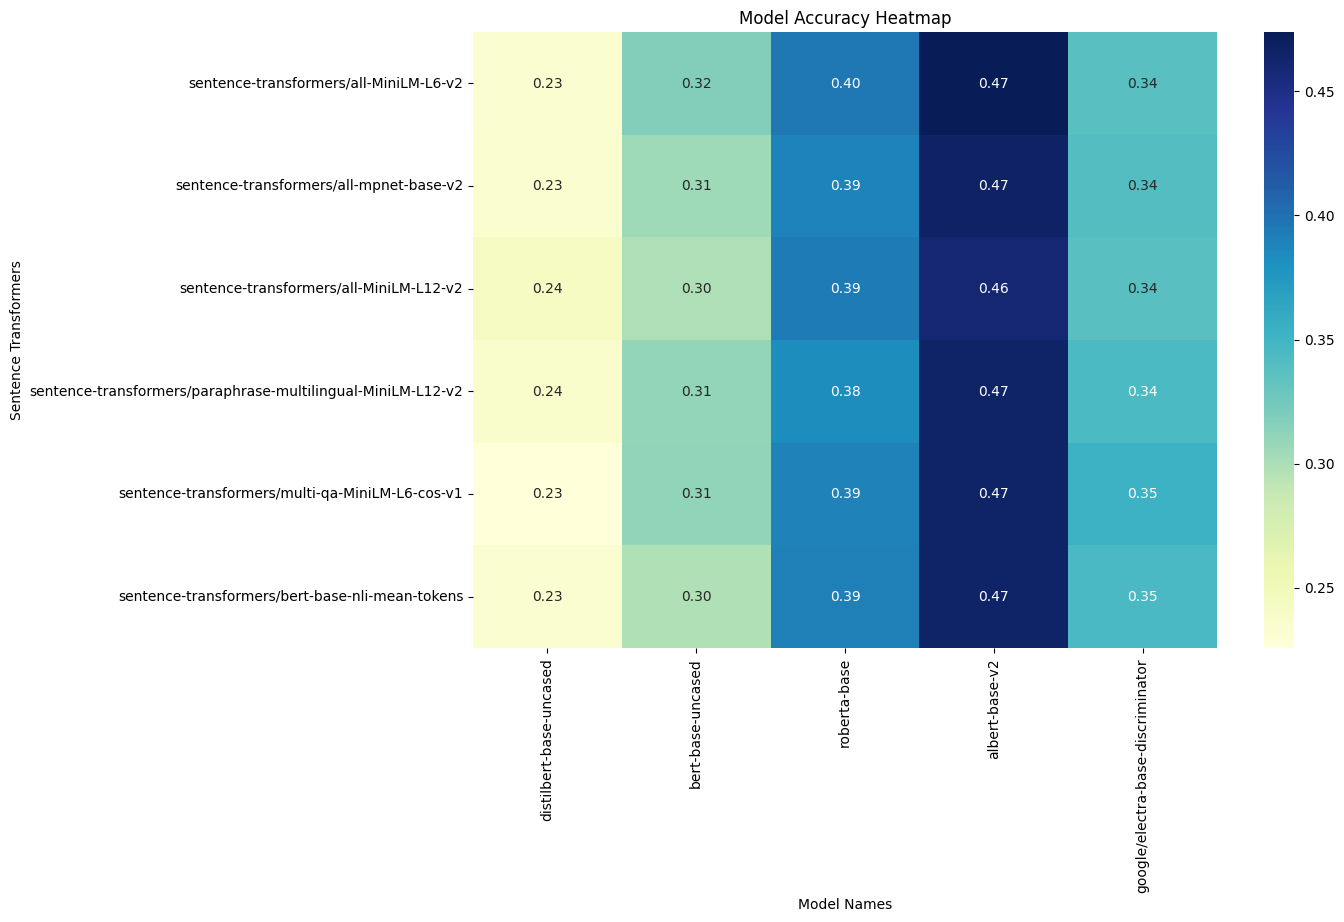

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Model Accuracy Heatmap')
plt.xlabel('Model Names')
plt.ylabel('Sentence Transformers')
plt.show()

Παρατηρούμε ότι το καλύτερο accuracy το έχει το albert-base-v2 και ότι οι Sentence Transformers δεν αλλάζουν σχεδόν καθόλου την επίδοση του κάθε μοντέλου




## Β3. Winogrande dataset

Το [Winogrande dataset](https://huggingface.co/datasets/winogrande) αποτελείται από προτάσεις που μία λέξη τους έχει αφαιρεθεί και δίνονται δύο πιθανές επιλογές συμπλήρωσης του κενού. Για παράδειγμα, δοθείσας της πρότασης "John moved the couch from the garage to the backyard to create space. The _ is small.", υπάρχουν δύο πιθανές εναλλακτικές:

- "garage"
- "backyard"

Η δυσκολία της συμπλήρωσης έγκειται στο ότι και οι δύο λέξεις αναφέρονται στην πρόταση, οπότε το μοντέλο θα πρέπει να διαθέτει υψηλές δυνατότητες κατανόησης γλώσσας προκειμένου να επιλέξει μια νοηματικά σωστή συμπλήρωση.

Για λόγους επιτάχυνσης, επιλέξτε ένα τυχαίο υποσύνολο 100 δειγμάτων από το training set του Winogrande.


In [ ]:
# insert your code here (load dataset)from datasets import load_dataset
import random

# Load the Winogrande dataset
dataset = load_dataset("winogrande", "winogrande_debiased")

# Select the training set
train_set = dataset['train']

# Set a random seed for reproducibility (optional)
random.seed(42)

# Select 100 random samples from the training set
subset = random.sample(list(train_set), 100)

# Display the subset
for i, example in enumerate(subset):
    print(f"{i+1}. {example}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for winogrande contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/winogrande
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/9248 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1267 [00:00<?, ? examples/s]

1. {'sentence': 'We wanted to go and take the plastic to the dump instead of all of the wood, because the _ is heavier.', 'option1': 'wood', 'option2': 'plastic', 'answer': '1'}
2. {'sentence': 'Katrina orders water at the bar, while Emily has a nice, cold beer, so _ is the sober person.', 'option1': 'Katrina', 'option2': 'Emily', 'answer': '1'}
3. {'sentence': 'The boy threw the frisbee instead of the ball for the dog to fetch, because the dog hated playing with the _ .', 'option1': 'frisbee', 'option2': 'ball', 'answer': '2'}
4. {'sentence': 'The painting stood out to Laura but not Rebecca because it reminded _ of their childhood.', 'option1': 'Laura', 'option2': 'Rebecca', 'answer': '1'}
5. {'sentence': 'Sarah was unable to find the job opening that they wanted at their school because the _ is small.', 'option1': 'school', 'option2': 'job', 'answer': '1'}
6. {'sentence': 'Lindsey was comforted by Erin, after _ saw the fight that lasted a very long time..', 'option1': 'Lindsey', 'opt

Με κατάλληλο [μετασχηματισμό](https://huggingface.co/DeepPavlov/roberta-large-winogrande) της παραπάνω εισόδου (πρόταση με κενό και δύο επιλογές συμπλήρωσης), καλείστε να καταγράψετε το accuracy σχετικών μοντέλων που επιλύουν το πρόβλημα, συγκρίνοντας το predicted label με το πραγματικό label (1: πρώτη επιλογή, 2: δεύτερη επιλογή). Ουσιαστικά θα πρέπει να αναγάγετε το παραπάνω πρόβλημα σε κάποιο πιο κλασικό πρόβλημα της επεξεργασίας φυσικής γλώσσας.

Δοκιμάστε τουλάχιστον 3 κατάλληλα μοντέλα από το Huggingface για να προσεγγίσετε το πρόβλημα του Winogrande. Προτείνουμε τη χρήση pipelines για τη διευκόλυνσή σας.

In [ ]:
# insert your code here (load models)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load the models and create pipelines
models = [
    "albert-base-v2",
    "sileod/deberta-v3-large-tasksource-nli",
    "DeepPavlov/roberta-large-winogrande"
]

In [ ]:
import numpy as np


# insert your code here (function for predicting best fill)
def predict_best_fill(model_name, subset):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    classification_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

    correct_predictions = 0
    total_predictions = 0

    for example in subset:
        sentence = example['sentence']
        option1 = example['option1']
        option2 = example['option2']
        answer = int(example['answer'])

        # Concatenate the sentence with each option to form two input sequences
        inputs = [sentence.replace('_', option1), sentence.replace('_', option2)]

        # Perform sequence classification to predict the best fill
        outputs = classification_pipeline(inputs)

        # Determine which option was predicted as correct
        predicted_label = np.argmax([output['score'] for output in outputs]) + 1  # Index starts from 0, so add 1 to match answer labels

        # Check if the predicted label matches the actual answer
        if predicted_label == answer:
            correct_predictions += 1

        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


In [ ]:
for model_name in models:
    accuracy = predict_best_fill(model_name, subset)
    print(f"Model: {model_name}, Accuracy: {accuracy}")

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: albert-base-v2, Accuracy: 0.53
Model: sileod/deberta-v3-large-tasksource-nli, Accuracy: 0.73
Model: DeepPavlov/roberta-large-winogrande, Accuracy: 0.64


|Model|Accuracy|
|--|--|
|albert-base-v2|0.54|
|sileod/deberta-v3-large-tasksource-nli|0.73|
|DeepPavlov/roberta-large-winogrande|0.64|

Παρατηρούμε ότι το καλύτερο Accuracy το πετυχαίνει το sileod/deberta-v3-large-tasksource-nli